Import packages & track runtime

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime


# Track total runtime
_start_time = datetime.now()

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Specify settings & parameters:

* **Hypotheses**: H0 & non-composite H1, for likelihood derivation simplicity
* **MDE**: minimal detectable effect
* **DGP Control & Treatment**: Bernoulli with known mean, sample sizes & True treatment effect
* **Prior**: prior influence (n, weight) and Beta-distributed (Conjugate)
* **Early stopping**: Toggle whether to activate or not, Stopping probability (if the likelihoods confidence in a hypothesis exceeds this value → terminate experiment), and the number of samples collected between interim testing
* **Loss function**



In [ ]:
"""
Part 0: Settings & Hyperparameters
"""
random.seed(1)

# H0: effect = 0, H1: effect = mde (note, not composite! though still practical for that purpose)
hypotheses = {"null": 0.6, "alt": 0.63, "mde": 0.01}
_relative_loss_theshold = 0.05 # Used for loss -> e.g. 0.05 = 5% of prior effect deviation is accepted

# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 10_000, "true_prob": 0.6}
T = {"n": 10_000, "true_prob": 0.52}

# Define Prior (Beta distributed -> Conjugate)
prior = {"n": 100, "weight": 100, "prior_control": 0.6, "prior_treatment": 0.63}

# Early Stopping parameters (criteria in % for intuitive use-cases)
sequential_testing = True
early_stopping = {"stopping_criteria_prob": 95, "interim_test_interval": 10}

Generates input data from **Bernoulli Distributions**. It gets the individual observations, number of "converted" observations and the corresponding conversion rate for both **Control & Treatment**.

In [ ]:
"""
Part 1: Generate Data
"""

def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structre
print(f"Control: {C['sample'][:10]}, Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")

Control: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1], Conversion_Rate = 0.6021 (true = 0.6) 
Treatment: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1], Conversion_Rate = 0.5146 (true = 0.52)


Here the **Bayes Factor for the Treatment group** is obtained by:

 $$BF_{H1|H0} = exp(log(BF_{H1|H0})) = exp(log(P[data|H1]) - log(P[data|H0])) = \frac{P[data|H1]}{P[data|H0]}$$

Which uses **log-likelihoods**. The log tranformation in between is important as the denominator of the regular Bayes factor can easily converge to 0 causing a zero-division problem if unaddressed.

log-likelihood Bernoulli:
$$  \log L(p; x) = \log(p^x (1 - p)^{1 - x}) = x \log p + (1 - x) \log(1 - p) $$





In [ ]:
"""
Part 2: Log Likelihoods
"""
# Log is important, to prevent "float division by zero" as data dimensions increase and likelihoods converge to 0
def bernoulli_log_likelihood(hypothesis, outcomes):
    log_likelihood = 0.0
    for y in outcomes:
        if y == 1:
            log_likelihood += np.log(hypothesis)
        elif y == 0:
            log_likelihood += np.log(1 - hypothesis)
        else:
            raise ValueError("Outcomes must contain non-negative integers")

    return log_likelihood

def log_likelihood_ratio_test(treatment):
    # Get likelihoods
    null_log_likelihood = bernoulli_log_likelihood(hypotheses["null"], treatment)
    alt_log_likelihood = bernoulli_log_likelihood(hypotheses["alt"], treatment)

    # Compute BF: H1|H0
    log_bayes_factor = alt_log_likelihood - null_log_likelihood
    bayes_factor = round(np.exp(log_bayes_factor), 3)

    return bayes_factor

T["bayes_factor"] = log_likelihood_ratio_test(T["sample"])


Optionally if *sequential_testing = True*, we activate **early stopping** (symmetric for accepting/rejecting H0), based on a pre-specified **hyperparameter k** that controls early stopping strictness.

The stopping rule instructs us to stop sampling if:

$$ BF_{H1|H0} > k \quad \text{or} \quad BF_{H1|H0} < \frac{1}{k} $$

Early stopping is determined by the Treatment sample, and then, we sample the **same number of observations from the control group**. In practical terms, this designs pushes a balanced control/treatment group, which in practice may not hold.

For programming convenience, Fixed Horizon observations (object: *T* & *C*) are not saved when early stopping is triggered. It is possible to change (efficiently) with more clever programming, but for now this suffices.

A stopping criteria of 95% yields a k of 19.0
we trigger early stopping if BF > UB = k = 19.0
                          or BF < LB = 1/k = 0.053

n: 10/10000, BF: 1.264
n: 20/10000, BF: 1.093
n: 30/10000, BF: 0.944
n: 40/10000, BF: 0.558
n: 50/10000, BF: 0.547
n: 60/10000, BF: 0.61
n: 70/10000, BF: 0.527
n: 80/10000, BF: 0.401
n: 90/10000, BF: 0.447
n: 100/10000, BF: 0.386
n: 110/10000, BF: 0.334
n: 120/10000, BF: 0.327
n: 130/10000, BF: 0.283
n: 140/10000, BF: 0.278
n: 150/10000, BF: 0.211
n: 160/10000, BF: 0.235
n: 170/10000, BF: 0.158
n: 180/10000, BF: 0.12
n: 190/10000, BF: 0.092
n: 200/10000, BF: 0.07
n: 210/10000, BF: 0.053
n: 220/10000, BF: 0.052


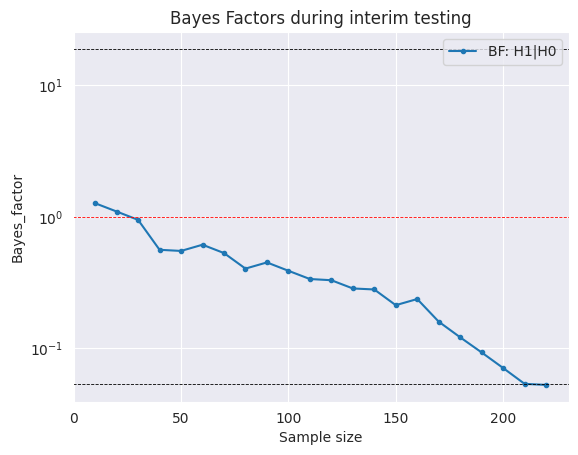

In [ ]:
"""
Part 2.5: Early Stopping
"""
# Explanation stopping rule
print(f"A stopping criteria of {early_stopping['stopping_criteria_prob']}% yields a k of {early_stopping['stopping_criteria_prob'] / (100 - early_stopping['stopping_criteria_prob'])}")
print(f"we trigger early stopping if BF > UB = k = {early_stopping['stopping_criteria_prob'] / (100 - early_stopping['stopping_criteria_prob'])}")
print(f"                          or BF < LB = 1/k = {round(1 / (early_stopping['stopping_criteria_prob'] / (100 - early_stopping['stopping_criteria_prob'])), 3)}\n")

def early_stopping_sampling(treatment):
    # Stopping criteria (symmetric) - computed using hyperparameter confidence %
    k =  early_stopping["stopping_criteria_prob"] / (100 - early_stopping["stopping_criteria_prob"])

    # Initialise
    bayes_factor, n_test = 0, 0
    early_stop = False
    interim_tests = []

    while early_stop == False:
        # sample
        n_test += 1
        n_observed = n_test * early_stopping["interim_test_interval"]

        # Full data set utilised
        if n_observed > T["n"]:
            break

        data_observed = treatment[:n_observed]
        bayes_factor = log_likelihood_ratio_test(data_observed)
        print(f"n: {n_observed}/{T['n']}, BF: {bayes_factor}")

        # Stopping criteria
        if (bayes_factor > k or bayes_factor < 1/k):
            early_stop = True

        interim_tests.append((n_observed, bayes_factor))

    # Format new collections of info on treatment/control (slice control based on sample size of early stopping)
    T_ES = {
        "sample": data_observed,
        "converted": sum(data_observed),
        "sample_conversion_rate": round(sum(data_observed) / n_observed, 3),
        "bayes_factor": bayes_factor,
        "interim_tests": interim_tests,
        "early_stop": early_stop,
        "n": n_observed,
        "n_test": n_test,
        "true_prob": T["true_prob"]
        }

    C_ES = {
        "sample": C["sample"][:n_observed],
        "converted": sum(C["sample"][:n_observed]),
        "sample_conversion_rate": round(sum(C["sample"][:n_observed]) / n_observed, 3),
        "n": n_observed,
        "true_prob": C["true_prob"]
        }

    return T_ES, C_ES, k

if sequential_testing == True:
    T_ES, C_ES, early_stopping["k"] = early_stopping_sampling(T["sample"])
    T, C = T_ES, C_ES


# Plot Bayes Factor Behaviour
def plot_bayes_factors(interim_tests):
    x, y = zip(*interim_tests)
    plt.plot(x, y, marker = ".", linestyle = "-", label = "BF: H1|H0")

    # plot stopping criteria
    plt.axhline(y = 1, color = "red", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = early_stopping["k"], color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/early_stopping["k"], color = "black", linestyle = "--", linewidth = "0.6")

    # Set the y-axis to log scale
    plt.yscale('log')

    plt.xlabel("Sample size")
    plt.ylabel("Bayes_factor")
    plt.legend()
    plt.title("Bayes Factors during interim testing")
    plt.plot()

if sequential_testing == True:
    plot_bayes_factors(T["interim_tests"])


The priors in this sandbox example follow a **Beta-Distribution (Beta(a,b))**. This decision follows from:

* It's a **conjugate prior**, i.e. the posterior will follow the same distribution, essentially simplifying following step A LOT.   
* Beta distribution works well for outcome variables in range (0, 1), which in this context are probabilities of conversion.

Additionally, two hyperparameter **n** (prior sample size) & **weight** are used to (somewhat) **control the prior influence**. Roughly speaking, a higher weight yields a prior with lower variance and hence stronger effect on the posterior distrbutions.

parameters a & b in Beta(a, b) are determined from the prior probability belief (specified above) as follows:

$$ a = weight * (P_{prior}) + 1 $$
$$ b = weight * (1 - P_{prior}) + 1 $$

The sample that is returned is sampled from this Beta distribution.

Based on Beta prior specification: {'n': 100, 'weight': 100, 'prior_control': 0.6, 'prior_treatment': 0.63}


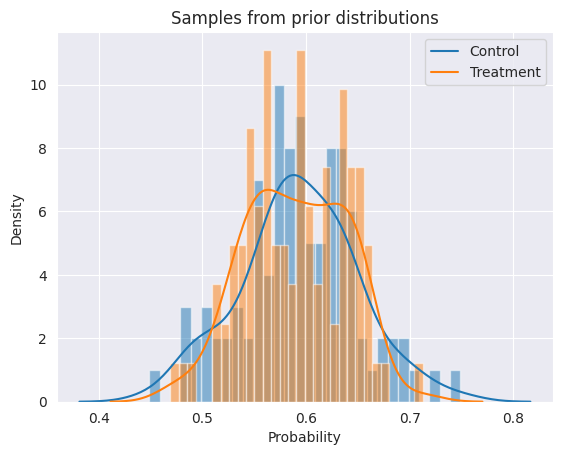

In [ ]:
"""
Part 3: Priors (Conjugate)
"""
def beta_prior(prior_prob, weight, n):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 1) * weight + 1
    b = (1 - round(prior_prob, 1)) * weight + 1
    beta_prior = stats.beta(a, b)
    samples = beta_prior.rvs(size = n)
    return beta_prior, samples, a, b

C["prior_dist"], C["prior_sample"], C["prior_beta_a"], C["prior_beta_b"] = beta_prior(prior["prior_control"], prior["weight"], prior["n"])
T["prior_dist"], T["prior_sample"], T["prior_beta_a"], T["prior_beta_b"] = beta_prior(prior["prior_treatment"], prior["weight"], prior["n"])

print(f"Based on Beta prior specification: {prior}")

def plot_priors():
    # Plot the histogram + kernel (Posterior)
    plt.hist(C["prior_sample"], bins = 30, alpha = 0.5, density=True, color = _colors[0])
    plt.hist(T["prior_sample"], bins = 30, alpha = 0.5, density=True, color = _colors[1])
    sns.kdeplot(C["prior_sample"], label='Control', fill = False, color = _colors[0])
    sns.kdeplot(T["prior_sample"], label='Treatment', fill = False, color = _colors[1])
    plt.xlabel('Probability')
    plt.legend()
    plt.title("Samples from prior distributions")
    plt.show()

plot_priors()


Given a (Conjugate) Beta-prior and a bernoulli DGP, the following simple posterior follows:

$$ Beta_{post}(a',b') = Beta(a_{prior} + n_{converted}, b_{prior} + (n - n_{converted}))$$

We sample from this distribution (with the same number of observations as the original DGP) for both control and treatment.

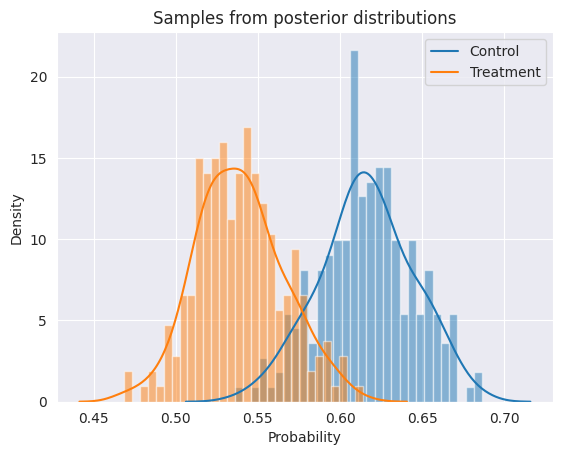

In [ ]:
"""
Part 4: Posteriors
"""
def beta_posterior(prior_a, prior_b, converted, n):
    # Beta distribution because prior Beta distribution is conjugate
    beta_posterior = stats.beta(prior_a + converted, prior_b + (n - converted))
    samples = beta_posterior.rvs(size = n)
    return beta_posterior, samples

C["post_dist"], C["post_sample"] = beta_posterior(C["prior_beta_a"], C["prior_beta_b"], C["converted"], C["n"])
T["post_dist"], T["post_sample"] = beta_posterior(T["prior_beta_a"], T["prior_beta_b"], T["converted"], T["n"])

def plot_posteriors():
    # Plot the histogram + kernel (Posterior)
    plt.hist(C["post_sample"], bins = 30, alpha = 0.5, density=True, color = _colors[0])
    plt.hist(T["post_sample"], bins = 30, alpha = 0.5, density=True, color = _colors[1])
    sns.kdeplot(C["post_sample"], label='Control', fill = False, color = _colors[0])
    sns.kdeplot(T["post_sample"], label='Treatment', fill = False, color = _colors[1])
    plt.xlabel('Probability')
    plt.legend()
    plt.title("Samples from posterior distributions")
    plt.show()

plot_posteriors()

Now we have all the tools to start reporting results. We can get the following numbers:

Treatment effect metrics
*  **True effect**
*  Observed effect (difference in DGP of Control & Treatment)
*  **Estimated effect (for both Control & Treatment)**
*  Prior effect (prior belief)

In terms of **relevant probabilities**, we can measure:

*   Posterior Probability of the treatment effect **exceeding the prespecified MDE (minimal detectable effect)** → P[TE > MDE]
*   Posterior probability of the the treatment group **exceeding the control group** → P[T > C]
* (Roughly speaking) Probability H1, i.e. **a significant effect, given the Bayes Factor** (Solely data-driven, no prior information) → P[H1|BF]

Based on the prior alongside a a-priori determined *acceptable loss threshold* (in %). We can formulate a loss function to determine which group (if any) performs well.

* Loss function for Treatment & Control

In [ ]:
"""
Part 5: Reporting (Metrics & Visualisations)
"""

# Print hypotheses:
print(f"\n===============================\nH0: y = {hypotheses['null']}, H1: y = {hypotheses['alt']}\nmde = {hypotheses['mde']} \n===============================")

def metrics():
    prob_H1 = round(T["bayes_factor"] / (T["bayes_factor"] + 1), 3)
    print(f"\nInformal probabilities: \nP[H1|BF]: {prob_H1}")

    # Evaluate how often treatment outperformes control
    treatment_won = [t - c >= hypotheses['mde'] for c, t in zip(C["post_sample"], T["post_sample"])]
    prob_TE_better_mde = round(np.mean(treatment_won), 2)
    print(f"posterior: P[T - C >= mde]: {prob_TE_better_mde}")
    treatment_won = [t >= c for c, t in zip(C["post_sample"], T["post_sample"])]
    prob_TE_positive = round(np.mean(treatment_won), 2)
    print(f"posterior: P[T >= C]: {prob_TE_positive}")



    # Get treatment effect measurement
    treatment_effect = {
            "true": round(T["true_prob"] - C["true_prob"], 4),
            "observed": round(T["sample_conversion_rate"] - C["sample_conversion_rate"], 4),
            "estimated": round(T["post_sample"].mean() - C["post_sample"].mean(), 4),
            "prior": round(prior["prior_treatment"] - prior["prior_control"], 4)
        }

    print(f"\nTreatment effect:\n- true: {treatment_effect['true']}\n- observed: {treatment_effect['observed']}\n- prior: {treatment_effect['prior']}\n- posterior: {treatment_effect['estimated']}")

    # Compute loss (Reward/Penalise not choosing probability closest to the truth, by difference |T-C|)
    loss_control = [max(j - i, 0) for i,j in zip(C["post_sample"], T["post_sample"])]
    loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
    loss_control = round(np.mean(loss_control), 4)

    loss_treatment = [max(i - j, 0) for i,j in zip(C["post_sample"], T["post_sample"])]
    loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
    loss_treatment = round(np.mean(loss_treatment), 4)

    print(f"\nLoss (acceptable <= {round(treatment_effect['prior'] * _relative_loss_theshold, 4)}):\n- Treatment: {loss_treatment}\n- Control: {loss_control}")

    return treatment_effect, loss_control, loss_treatment, prob_TE_better_mde, prob_TE_positive

treatment_effect, C["loss"], T["loss"], treatment_effect["p[TE>mde]"], treatment_effect["p[T>C]"] = metrics()

# Print execution time
print(f"\n===============================\nTotal runtime:  {datetime.now() - _start_time}")



H0: y = 0.6, H1: y = 0.63
mde = 0.01 

Informal probabilities: 
P[H1|BF]: 0.049
posterior: P[T - C >= mde]: 0.03
posterior: P[T >= C]: 0.03

Treatment effect:
- true: -0.08
- observed: -0.114
- prior: 0.03
- posterior: -0.077

Loss (acceptable <= 0.0015):
- Treatment: 0.0776
- Control: 0.0006

Total runtime:  0:00:03.699074
